#Load Library

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize

import pickle
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from gensim.models import FastText
from gensim.models import Word2Vec


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

import pandas as pd
from tabulate import tabulate

from operator import attrgetter

torch.manual_seed(1)

import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mounted at /content/drive


#Load data

In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/COMP5046-NLP-AS2/Data/train.csv")
testing_data = pd.read_csv("/content/drive/MyDrive/COMP5046-NLP-AS2/Data/test_without_labels.csv")
validation_data = pd.read_csv("/content/drive/MyDrive/COMP5046-NLP-AS2/Data/val.csv")

In [ ]:
training_data[100:200]

,sents,labels
100,lmao,O
101,captain obvious,O O
102,ggwp,S
103,lol,O
104,right,O
...,...,...
195,you did not dc,P O O O
196,end,O
197,try hard,O O
198,end pls nomas,O O O


In [ ]:
print('Training data shape is: ',training_data.shape)
print('Testing data shape is: ',testing_data.shape)
print('Validation data shape is: ',validation_data.shape)

Training data shape is:  (26078, 2)
Testing data shape is:  (500, 1)
Validation data shape is:  (8705, 2)


#Data pre-processing

In [ ]:
# Extract the labels and sents and store into List

# Get the list of training data (sents)
training_sents=training_data['sents'].tolist()
# Get the list of corresponding labels for the training data 
training_labels=training_data['labels'].tolist()

# Get the list of validation data (sents)
validation_sents=validation_data['sents'].tolist()
# Get the list of corresponding labels for the validation data
validation_labels=validation_data['labels'].tolist()

# Get the list of testing data (sents)
testing_sents=testing_data['sents'].tolist()


In [ ]:
# PreProcess - remove [ ] from SEPA
training_sents_without_bk =[]
for i in range(len(training_sents)):
  training_sents_without_bk.append(training_sents[i].replace('[','').replace(']',''))

validation_sents_without_bk =[]
for i in range(len(validation_sents)):
  validation_sents_without_bk.append(validation_sents[i].replace('[','').replace(']',''))

testing_sents_without_bk =[]
for i in range(len(testing_sents)):
  testing_sents_without_bk.append(testing_sents[i].replace('[','').replace(']',''))


In [ ]:
#Dont have to delete this part, it is a good example that we might can discuss in our report about this evaluation
'''
# tokenized training sents
tokensized_training_docs=[]
for i in range (0,len(training_sents_without_bk)):
  tokenized_doc = word_tokenize(training_sents_without_bk[i]) #Tokenize words
  tokensized_training_docs.append(tokenized_doc)

# tokenized validation sents
tokensized_validation_docs=[]
for i in range (0,len(validation_sents_without_bk)):
  tokenized_doc = word_tokenize(validation_sents_without_bk[i]) #Tokenize words
  tokensized_validation_docs.append(tokenized_doc)
  
# tokenized testing sents
tokensized_testing_docs=[]
for i in range (0,len(testing_sents_without_bk)):
  tokenized_doc = word_tokenize(testing_sents_without_bk[i]) #Tokenize words
  tokensized_testing_docs.append(tokenized_doc)
'''

In [ ]:
# tokenized training sents
tokensized_training_docs=[]
for i in training_sents_without_bk:
  #print('inpout I is:', i)
  sub_list=list()
  i=i.split(" ")
  for b in i:
    sub_list.append(b.lower())
  tokensized_training_docs.append(sub_list)
  #print('output is: ',sub_list )

# tokenized validation sents
tokensized_validation_docs=[]
for i in validation_sents_without_bk:
  sub_list=list()
  i=i.split(" ")
  for b in i:
    sub_list.append(b.lower())
  tokensized_validation_docs.append(sub_list)

# tokenized testing sents
tokensized_testing_docs=[]
for i in testing_sents_without_bk:
  sub_list=list()
  i=i.split(" ")
  for b in i:
    sub_list.append(b.lower())
  tokensized_testing_docs.append(sub_list)

In [ ]:
# tokenized training labels
tokensized_training_label_docs=[]
for i in training_labels:
  b=i.split(" ")
  sub_label=list()
  for token in b:
    sub_label.append(token)
  tokensized_training_label_docs.append(sub_label)


# tokenized validation labels
tokensized_validation_label_docs=[]
for i in validation_labels:
  b=i.split(" ")
  sub_label=list()
  for token in b:
    sub_label.append(token)
  tokensized_validation_label_docs.append(sub_label)


In [ ]:
#example training docs
tokensized_training_docs[0:10]

[['wow'],
 ['wtf'],
 ['wpe', 'wpe'],
 ['hahaha'],
 ['wtf'],
 ['i', 'cant', 'sepa', 'play', 'sepa', 'with', '4', 'trash'],
 ['bg'],
 ['#error!'],
 ['gg', 'sepa', 'report', 'my', 'team', 'rat', 'sepa', 'please'],
 ['ez', 'mid']]

In [ ]:
#example training docs
tokensized_training_label_docs[0:10]

[['O'],
 ['T'],
 ['O', 'O'],
 ['O'],
 ['T'],
 ['P', 'O', 'SEPA', 'O', 'SEPA', 'O', 'O', 'O'],
 ['O'],
 ['O'],
 ['S', 'SEPA', 'S', 'P', 'O', 'S', 'SEPA', 'O'],
 ['S', 'S']]

99611
['O', 'T', 'O', 'O', 'O', 'T', 'P', 'O', 'SEPA', 'O']
Counter({'O': 56815, 'P': 11997, 'SEPA': 10418, 'S': 10035, 'C': 4780, 'T': 4292, 'D': 1274})


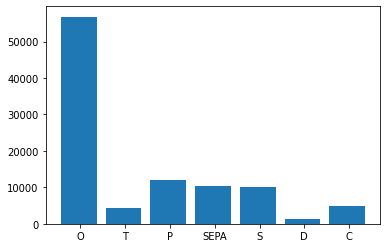

In [ ]:
all_label_flat=[]
for i in tokensized_training_label_docs:
  for t in i:
    all_label_flat.append(t)
print(len(all_label_flat))
print(all_label_flat[:10])
print (Counter(all_label_flat))
from collections import Counter
import matplotlib.pyplot as plt

labels, values = zip(*Counter(all_label_flat).items())

indexes = np.arange(len(labels))
width = 0.8

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.05, labels)
plt.show()

In [ ]:
#Test if there is a mismatch between tokensized train data and train label
count=0
for a,b in zip(tokensized_validation_docs, tokensized_validation_label_docs):
  count+=1
  if len(a)==len(b):
   print('All good')
  else:
    print('mismatch here: ', count)

In [ ]:
len(tokensized_training_label_docs)

26078

### Label encoding

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
#Create a dict for labels

label_set=set()

for i in training_labels:
  b=i.split(" ")
  for token in b:
    label_set.add(token)

label_set.add(START_TAG)
label_set.add(STOP_TAG)

tag_to_ix = {"C": 0, "D": 1, "O": 2, "P":3, "S":4, "SEPA":5, "T":6, "<START>": 7, "<STOP>": 8}
ix_to_tag= {0:"C", 1:"D", 2:"O", 3:"P", 4:"S", 5:"SEPA", 6:"T", 7:"<START>", 8:"<STOP>"}

In [ ]:
label_set

{'<START>', '<STOP>', 'C', 'D', 'O', 'P', 'S', 'SEPA', 'T'}

###Convert dataset into index

In [ ]:
#combine 3 data sets to generate word list
tokensized_sents_full=tokensized_training_docs+tokensized_validation_docs+tokensized_testing_docs
unique_word_set=set()
for sent in tokensized_sents_full:
  for word in sent:
    unique_word_set.add(word)

word_list=list(unique_word_set)
word_list.sort()
word_dict = {w: i for i, w in enumerate(word_list)}

print(len(word_list))

11240


In [ ]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

#input index
train_input_index =  to_index(tokensized_training_docs,word_dict)
train_output_index = to_index(tokensized_training_label_docs,tag_to_ix)

val_input_index = to_index(tokensized_validation_docs,word_dict)
val_output_index = to_index(tokensized_validation_label_docs,tag_to_ix)

test_input_index = to_index(tokensized_testing_docs,word_dict)


#Evaluation function

In [ ]:
def calculate_f1(y_pred, y_true):
  y_pred=np.array(y_pred)
  y_true=np.array(y_true)

  f1=f1_score(y_pred, y_true, average='micro')
  f1_T_label=f1_score(y_pred[y_true==tag_to_ix['T']], y_true[y_true==tag_to_ix['T']], average='micro')
  f1_S_label=f1_score(y_pred[y_true==tag_to_ix['S']], y_true[y_true==tag_to_ix['S']], average='micro')
  f1_P_label=f1_score(y_pred[y_true==tag_to_ix['P']], y_true[y_true==tag_to_ix['P']], average='micro')
  f1_O_label=f1_score(y_pred[y_true==tag_to_ix['O']], y_true[y_true==tag_to_ix['O']], average='micro')
  f1_D_label=f1_score(y_pred[y_true==tag_to_ix['D']], y_true[y_true==tag_to_ix['D']], average='micro')
  f1_C_label=f1_score(y_pred[y_true==tag_to_ix['C']], y_true[y_true==tag_to_ix['C']], average='micro')

  return f1, f1_T_label ,f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label


# Input Embedding

##Syntactic Textual Feature Embedding
e.g. : PoS tag information, Dependency Path, etc

###POS

In [ ]:
# generate lookup info for POS one hot encoding 
import spacy
nlp = spacy.load("en_core_web_sm")

POS =[]
POS_set = set()

# use nlp.pipe() instead of nlp() to process multiple texts more efficiently
for doc in nlp.pipe(word_list):
    if len(doc) > 0:
        POS.append(doc[0].pos_)
        POS_set.add(doc[0].pos_)
print(len(POS))  #------ POS has all the name of POS e.g X, PUNCT

# generate unique list of POS taggers
POS_list=list(POS_set)

# Convert to array to put in Sklearn Encoders
POS_list.sort()
values = array(POS_list)
print(values)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# Generate POS tagging index dictionary, e.g ADJ : 0 
POS_index = {}
ind = 0
for word in POS_list:
    POS_index[word] = ind
    ind += 1
print(POS_index)

11240
['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON'
 'PROPN' 'PUNCT' 'SCONJ' 'SYM' 'VERB' 'X']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0

In [ ]:
#generate POS one hot encoding for word_list

#generate index of each sentence e.g 2,7,etc
list_index=[]
for i in POS: #POS_all [0:5]:
  list_index.append(POS_index[i])

# convert index to onehot_encoded
POS2Vector = []
for i in list_index:
  POS2Vector.append(onehot_encoded[i])

print(len(POS2Vector))
POS_embedding_matrix = np.array(POS2Vector)
print(POS_embedding_matrix.shape)

11240
(11240, 17)


In [ ]:
POS_embedding_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
#example of POS2Vector
print(POS[0:10])
print(POS2Vector[0:10])

['NOUN', 'PUNCT', 'PUNCT', 'PUNCT', 'NUM', 'NUM', 'NUM', 'X', 'PUNCT', 'NUM']
[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])]


##Semantic Textual Feature Embedding
e.g.Word Embeddings (Word2Vec, ELMO, etc.

###Word2Vec-Skipgram

In [ ]:
#train a skip-gram W2V model
w2v_sg_model = Word2Vec(tokensized_sents_full, size=200, window=5, min_count=1, workers=4, sg=1)

In [ ]:
print(word_dict.items())
print(len(word_dict))

dict_items([('#error!', 0), ('.', 1), ('0', 2), ('00', 3), ('000', 4), ('000000', 5), ('000000000000000', 6), ('00100', 7), ('0162282307', 8), ('025', 9), ('040', 10), ('06', 11), ('0:00', 12), ('0coins', 13), ('0o', 14), ('0v5', 15), ('0ward', 16), ('1', 17), ('1.', 18), ('10', 19), ('100', 20), ('1000', 21), ('10000', 22), ('100000', 23), ('100hp', 24), ('101', 25), ('10120', 26), ('102', 27), ('103', 28), ('10k', 29), ('10min', 30), ('10mins', 31), ('10pm', 32), ('10x', 33), ('11', 34), ('110', 35), ('1110', 36), ('113', 37), ('113924617', 38), ('115', 39), ('1150', 40), ('118', 41), ('1188', 42), ('119', 43), ('11mins', 44), ('11pm', 45), ('12', 46), ('120s', 47), ('12k', 48), ('12mins', 49), ('12y', 50), ('13', 51), ('130cannot', 52), ('134', 53), ('1389461397419', 54), ('13:8', 55), ('13mins', 56), ('14', 57), ('1400', 58), ('143', 59), ('1450', 60), ('149', 61), ('15', 62), ('150', 63), ('1500', 64), ('15200', 65), ('1584', 66), ('15min', 67), ('15y', 68), ('16', 69), ('1600', 7

In [ ]:
emb_table = []

w2v_sg_emb_dim=w2v_sg_model.vector_size

for i, word in enumerate(word_list):
    if word in w2v_sg_model:
        emb_table.append(w2v_sg_model[word])
    else:
        # The pretrained glove twitter does not contain the embeddings for the [PAD] and [UNKNOWN] tokens we defined
        # Here, we just use all 0 for both [PAD] and [UNKNOWN] tokens for simplicity
        emb_table.append([0]*w2v_sg_emb_dim)
w2v_sg_emb_table = np.array(emb_table).astype('float')
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
print('The shape of input embedding table is: ', w2v_sg_emb_table.shape)

The shape of input embedding table is:  (11240, 200)


###FastText

In [ ]:
w2v_ft_model = FastText(tokensized_sents_full, size=200, window=5, min_count=1, workers=4, sg=1)

emb_table = []

w2v_ft_emb_dim=w2v_ft_model.vector_size

for i, word in enumerate(word_list):
    if word in w2v_ft_model:
        emb_table.append(w2v_ft_model[word])
    else:
        # The pretrained glove twitter does not contain the embeddings for the [PAD] and [UNKNOWN] tokens we defined
        # Here, we just use all 0 for both [PAD] and [UNKNOWN] tokens for simplicity
        emb_table.append([0]*w2v_ft_emb_dim)
w2v_ft_emb_table = np.array(emb_table).astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


##Domain Feature Embedding
e.g. Your own new feature embedding to solve this in-game chat word slot filling(tagging)

In [ ]:
import json

with open('/content/drive/MyDrive/COMP5046-NLP-AS2/Data/domain_docs.json','r') as f:
  data=json.load(f)

domain_docs=(data['data'])
print(len(domain_docs))

5435


In [ ]:
#train a skip-gram W2V model
# training corpus = domain_docs + full tokenized sentences
domain_sg_model = Word2Vec(domain_docs+tokensized_sents_full, size=200, window=5, min_count=1, workers=4, sg=1)

In [ ]:
emb_table = []

domain_sg_emb_dim=domain_sg_model.vector_size

for i, word in enumerate(word_list):
    if word in domain_sg_model:
        emb_table.append(domain_sg_model[word])
    else:
        # The pretrained glove twitter does not contain the embeddings for the [PAD] and [UNKNOWN] tokens we defined
        # Here, we just use all 0 for both [PAD] and [UNKNOWN] tokens for simplicity
        emb_table.append([0]*domain_sg_emb_dim)
domain_sg_emb_table = np.array(emb_table).astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
print(domain_sg_emb_table.shape)

(11240, 200)


### Concatenate POS +W2V

In [ ]:
#this concatenate is from the embedding table level - POS table + w2v table
w2v_POS_emb_table=np.concatenate((w2v_sg_emb_table,POS_embedding_matrix),axis=1)

In [ ]:
w2v_POS_emb_table.shape

(11240, 217)

### Concatenate POS + FastText

In [ ]:
ft_POS_emb_table=np.concatenate((w2v_ft_emb_table,POS_embedding_matrix),axis=1)

### Concatenate POS + domain

In [ ]:
POS_domain_emb_table=np.concatenate((POS_embedding_matrix,domain_sg_emb_table),axis=1)
POS_domain_emb_table.shape

(11240, 217)

### Concatenate POS + w2v + domain

In [ ]:
w2v_POS_domain_emb_table=np.concatenate((w2v_POS_emb_table,domain_sg_emb_table),axis=1)
w2v_POS_domain_emb_table.shape

(11240, 417)

### Concatenate POS + ft + domain

In [ ]:
ft_POS_domain_emb_table=np.concatenate((ft_POS_emb_table,domain_sg_emb_table),axis=1)
ft_POS_domain_emb_table.shape

(11240, 417)

#Helper function to make the code more readable

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

#cal_acc 
def cal_acc(model, input_index, output_index):
    ground_truth = []
    predicted = []
    for i,idxs in enumerate(input_index):
        ground_truth += output_index[i]
        score, pred = model(torch.tensor(idxs, dtype=torch.long).to(device))
        predicted += pred
    accuracy = sum(np.array(ground_truth) == np.array(predicted))/len(ground_truth)
    return predicted, ground_truth, accuracy

# Baseline Model-Bi-LSTM with CRF
Copy the code from previous notbook lab

##Build baseline Model

In [ ]:
# construct baseline model
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix,embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

## Training

In [ ]:
# use w2v_sg_emb_table as embedding table & num layer = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM=200

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
# Training
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 21611.06, train acc: 0.9877, val loss: 2477.36, val acc: 0.9843, time: 549.16s
Epoch:2, Training loss: 4805.30, train acc: 0.9951, val loss: 1749.16, val acc: 0.9906, time: 548.83s


##Save and load model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/baseline_CRF_bilstm_model_1.pt')

In [ ]:
baseline_CRF_bilstm_model_1=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/baseline_CRF_bilstm_model_1.pt')

##Evaluation

In [ ]:
# Check predictions after training e.g tokensized_training_docs[8]
with torch.no_grad():
    precheck_sent = prepare_sequence(tokensized_training_docs[8], word_dict).to(device)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in tokensized_training_label_docs[8]], dtype=torch.long).to(device)
    print(model(precheck_sent))

(tensor(90.9989, device='cuda:0'), [4, 5, 4, 3, 2, 4, 5, 2])


In [ ]:
print(train_output_index[8])
print(tokensized_training_label_docs[8])

[4, 5, 4, 3, 2, 4, 5, 2]
['S', 'SEPA', 'S', 'P', 'O', 'S', 'SEPA', 'O']


In [ ]:
baseline_CRF_bilstm_model_1.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=baseline_CRF_bilstm_model_1(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

In [ ]:
Eval_Model_Name = []
Eval_result =[]

#Manually put the result in the table as the below might not be run again.
#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]
        ]
col_names=["baseline_CRF_bilstm_model_1","F1 Score"]

Eval_Model_Name.append("baseline_CRF_bilstm_model_1")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════════╤════════════╕
│ baseline_CRF_bilstm_model_1   │   F1 Score │
╞═══════════════════════════════╪════════════╡
│ F1                            │   0.990466 │
├───────────────────────────────┼────────────┤
│ F1 (T)                        │   0.947583 │
├───────────────────────────────┼────────────┤
│ F1 (S)                        │   0.986454 │
├───────────────────────────────┼────────────┤
│ F1 (P)                        │   0.995935 │
├───────────────────────────────┼────────────┤
│ F1 (O)                        │   0.996313 │
├───────────────────────────────┼────────────┤
│ F1 (D)                        │   0.871859 │
├───────────────────────────────┼────────────┤
│ F1 (C)                        │   0.964046 │
╘═══════════════════════════════╧════════════╛


# Model - Bi-LSTM CRF - Word2Vector

##Build Model

In [ ]:
#add embedding matrix as the initial weights of nn.Embedding

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix,embedding_dim, hidden_dim,emb_table,num_layers):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = num_layers

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(w2v_sg_emb_dim)) 
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(emb_table))) # need to replace w2v_sg_emb_dim to other embedding table
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=num_layers, bidirectional=True)



        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2*num_layers, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*num_layers, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

##Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB = w2v_sg_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1


model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))



Epoch:1, Training loss: 22524.07, train acc: 0.9948, val loss: 1381.17, val acc: 0.9926, time: 938.46s
Epoch:2, Training loss: 1802.19, train acc: 0.9990, val loss: 1011.95, val acc: 0.9955, time: 902.26s


##Save and Load model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/w2v_CRF_bilstm_model.pt')

In [ ]:
w2v_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/w2v_CRF_bilstm_model.pt')

##Evaluation

In [ ]:
w2v_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=w2v_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]
col_names=["w2v_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("w2v_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒════════════════════════╤════════════╕
│ w2v_CRF_bilstm_model   │   F1 Score │
╞════════════════════════╪════════════╡
│ F1                     │   0.995473 │
├────────────────────────┼────────────┤
│ F1 (T)                 │   0.965963 │
├────────────────────────┼────────────┤
│ F1 (S)                 │   0.992775 │
├────────────────────────┼────────────┤
│ F1 (P)                 │   0.997713 │
├────────────────────────┼────────────┤
│ F1 (O)                 │   1        │
├────────────────────────┼────────────┤
│ F1 (D)                 │   0.937186 │
├────────────────────────┼────────────┤
│ F1 (C)                 │   0.973796 │
╘════════════════════════╧════════════╛


#Model-BI-LSTM-FastText

##Build Model

In [ ]:
#add embedding matrix as the initial weights of nn.Embedding

class BiLSTM_CRF_FT(nn.Module):

    def __init__(self, vocab_size, tag_to_ix,embedding_dim, hidden_dim,emb_table,num_layers):
        super(BiLSTM_CRF_FT, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = num_layers

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(w2v_sg_emb_dim)) 
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(emb_table))) # need to replace w2v_sg_emb_dim to other embedding table
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=num_layers, bidirectional=True)



        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2*num_layers, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*num_layers, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

##Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB = w2v_ft_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1


model = BiLSTM_CRF_FT(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))



Epoch:1, Training loss: 21021.59, train acc: 0.9956, val loss: 1322.26, val acc: 0.9923, time: 541.56s
Epoch:2, Training loss: 1551.57, train acc: 0.9994, val loss: 992.94, val acc: 0.9953, time: 541.75s


##Save and load model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_CRF_bilstm_model.pt')
ft_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_CRF_bilstm_model.pt')

##Evaluation

In [ ]:
ft_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=ft_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]
col_names=["ft_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("ft_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

NameError: ignored

In [ ]:
ft_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):


  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=ft_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

table_2= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]
    
        ]
col_names=["F1 Labels","F1 Score"]

print(tabulate(table_2, headers=col_names,tablefmt='fancy_grid'))

╒═════════════╤════════════╕
│ F1 Labels   │   F1 Score │
╞═════════════╪════════════╡
│ F1          │   0.995323 │
├─────────────┼────────────┤
│ F1 (T)      │   0.968686 │
├─────────────┼────────────┤
│ F1 (S)      │   0.992173 │
├─────────────┼────────────┤
│ F1 (P)      │   0.99873  │
├─────────────┼────────────┤
│ F1 (O)      │   0.998947 │
├─────────────┼────────────┤
│ F1 (D)      │   0.947236 │
├─────────────┼────────────┤
│ F1 (C)      │   0.976843 │
╘═════════════╧════════════╛


#Model - Bi-LSTM CRF - POS tag only

####Training


In [ ]:
#POS_embedding_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=POS_embedding_matrix
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1

#need to replace the embedding table e.g. POS_embedding_matrix
model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 33818.76, train acc: 0.9884, val loss: 2223.29, val acc: 0.9864, time: 884.12s
Epoch:2, Training loss: 3329.37, train acc: 0.9978, val loss: 1280.10, val acc: 0.9944, time: 880.68s


####Save and Load model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_CRF_bilstm_model.pt')

In [ ]:
ft_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_CRF_bilstm_model.pt')

####Evaluation

In [ ]:
ft_CRF_bilstm_model.eval()
predict=[]
true_label =[]

for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=ft_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]
col_names=["ft_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("ft_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

NameError: ignored

#Model - Bi-LSTM CRF - Word2Vector + POS

##Training

In [ ]:
#w2v_POS_emb_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 19862.46, train acc: 0.9951, val loss: 1247.18, val acc: 0.9930, time: 549.24s
Epoch:2, Training loss: 1784.31, train acc: 0.9990, val loss: 950.06, val acc: 0.9954, time: 549.91s


## Save and Load Model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_w2v_CRF_bilstm_model.pt')

In [ ]:
POS_w2v_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_w2v_CRF_bilstm_model.pt')

##Evaluation

In [ ]:
POS_w2v_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=POS_w2v_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["POS_w2v_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("POS_w2v_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒════════════════════════════╤════════════╕
│ POS_w2v_CRF_bilstm_model   │   F1 Score │
╞════════════════════════════╪════════════╡
│ F1                         │   0.994483 │
├────────────────────────────┼────────────┤
│ F1 (T)                     │   0.957114 │
├────────────────────────────┼────────────┤
│ F1 (S)                     │   0.987959 │
├────────────────────────────┼────────────┤
│ F1 (P)                     │   0.99873  │
├────────────────────────────┼────────────┤
│ F1 (O)                     │   0.999684 │
├────────────────────────────┼────────────┤
│ F1 (D)                     │   0.937186 │
├────────────────────────────┼────────────┤
│ F1 (C)                     │   0.972578 │
╘════════════════════════════╧════════════╛


# Model - Bi-LSTM CRF - POS + Domain 

## Training

In [ ]:
#POS_domain_emb_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 20550.45, train acc: 0.9936, val loss: 1364.74, val acc: 0.9921, time: 873.85s
Epoch:2, Training loss: 1951.37, train acc: 0.9983, val loss: 955.89, val acc: 0.9953, time: 878.60s


## Save and Load Model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_domain_CRF_bilstm_model.pt')

In [ ]:
POS_domain_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_domain_CRF_bilstm_model.pt')

## Evaluation

In [ ]:
POS_domain_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=POS_domain_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["POS_domain_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("POS_domain_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════════╤════════════╕
│ POS_domain_CRF_bilstm_model   │   F1 Score │
╞═══════════════════════════════╪════════════╡
│ F1                            │   0.995233 │
├───────────────────────────────┼────────────┤
│ F1 (T)                        │   0.967325 │
├───────────────────────────────┼────────────┤
│ F1 (S)                        │   0.991872 │
├───────────────────────────────┼────────────┤
│ F1 (P)                        │   0.998222 │
├───────────────────────────────┼────────────┤
│ F1 (O)                        │   0.999842 │
├───────────────────────────────┼────────────┤
│ F1 (D)                        │   0.917085 │
├───────────────────────────────┼────────────┤
│ F1 (C)                        │   0.975015 │
╘═══════════════════════════════╧════════════╛


# Model - Bi-LSTM CRF - Word2Vector + POS + Domain 

## Training

In [ ]:
#w2v_POS_domain_emb_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=1

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 17877.41, train acc: 0.9953, val loss: 1241.62, val acc: 0.9936, time: 600.43s
Epoch:2, Training loss: 1818.68, train acc: 0.9990, val loss: 874.65, val acc: 0.9956, time: 570.08s


## Save and Load Model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_w2v_domain_CRF_bilstm_model.pt')

In [ ]:
POS_w2v_domain_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/POS_w2v_domain_CRF_bilstm_model.pt')

## Evaluation

In [ ]:
POS_w2v_domain_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=POS_w2v_domain_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]
col_names=["POS_w2v_domain_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("POS_w2v_domain_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════════════╤════════════╕
│ POS_w2v_domain_CRF_bilstm_model   │   F1 Score │
╞═══════════════════════════════════╪════════════╡
│ F1                                │   0.995593 │
├───────────────────────────────────┼────────────┤
│ F1 (T)                            │   0.965963 │
├───────────────────────────────────┼────────────┤
│ F1 (S)                            │   0.992173 │
├───────────────────────────────────┼────────────┤
│ F1 (P)                            │   0.99873  │
├───────────────────────────────────┼────────────┤
│ F1 (O)                            │   0.999895 │
├───────────────────────────────────┼────────────┤
│ F1 (D)                            │   0.947236 │
├───────────────────────────────────┼────────────┤
│ F1 (C)                            │   0.973796 │
╘═══════════════════════════════════╧════════════╛


# Comparison Table _Word Embedding

In [ ]:
result_df = pd.DataFrame(columns=['F1', 'F1 (T)', 'F1 (S)','F1 (P)','F1 (O)','F1 (D)','F1 (C) '])
for i in range(len(Eval_result)):
    result_df.loc[i] = Eval_result[i]

result_df.index = Eval_Model_Name
result_df

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
baseline_CRF_bilstm_model_1,0.990466,0.947583,0.986454,0.995935,0.996313,0.871859,0.964046
w2v_CRF_bilstm_model,0.995473,0.965963,0.992775,0.997713,1.000000,0.937186,0.973796
POS_only_CRF_bilstm_model,0.994304,0.956433,0.987959,0.998222,0.999737,0.927136,0.972578
POS_w2v_CRF_bilstm_model,0.994483,0.957114,0.987959,0.998730,0.999684,0.937186,0.972578
POS_domain_CRF_bilstm_model,0.995233,0.967325,0.991872,0.998222,0.999842,0.917085,0.975015
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796


# Model - Number of layers 

At least 2 different numbers for stacked layers 

## Training

In [ ]:
#use the best embedding method from above

#w2v_POS_domain_emb_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=2

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 29862.28, train acc: 0.9921, val loss: 1559.75, val acc: 0.9895, time: 570.52s
Epoch:2, Training loss: 2563.38, train acc: 0.9973, val loss: 1068.95, val acc: 0.9943, time: 571.82s


## Save and Load Model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/twolayer_CRF_bilstm_model.pt')

In [ ]:
twolayer_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/twolayer_CRF_bilstm_model.pt')

## Evaluation

In [ ]:
twolayer_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=twolayer_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["twolayer_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("twolayer_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═════════════════════════════╤════════════╕
│ twolayer_CRF_bilstm_model   │   F1 Score │
╞═════════════════════════════╪════════════╡
│ F1                          │   0.994483 │
├─────────────────────────────┼────────────┤
│ F1 (T)                      │   0.960517 │
├─────────────────────────────┼────────────┤
│ F1 (S)                      │   0.990066 │
├─────────────────────────────┼────────────┤
│ F1 (P)                      │   0.998984 │
├─────────────────────────────┼────────────┤
│ F1 (O)                      │   0.999737 │
├─────────────────────────────┼────────────┤
│ F1 (D)                      │   0.896985 │
├─────────────────────────────┼────────────┤
│ F1 (C)                      │   0.973796 │
╘═════════════════════════════╧════════════╛


## 3-layers

In [ ]:
#use the best embedding method from above

#w2v_POS_domain_emb_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
num_layers=3

model = BiLSTM_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,EMBEDDING_TAB,num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))



In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/threelayer_CRF_bilstm_model.pt')

In [ ]:
threelayer_CRF_bilstm_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/threelayer_CRF_bilstm_model.pt')

In [ ]:
threelayer_CRF_bilstm_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):

  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=threelayer_CRF_bilstm_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["threelayer_CRF_bilstm_model","F1 Score"]

Eval_Model_Name.append("threelayer_CRF_bilstm_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))


╒═══════════════════════════════╤════════════╕
│ threelayer_CRF_bilstm_model   │   F1 Score │
╞═══════════════════════════════╪════════════╡
│ F1                            │   0.984919 │
├───────────────────────────────┼────────────┤
│ F1 (T)                        │   0.924438 │
├───────────────────────────────┼────────────┤
│ F1 (S)                        │   0.975918 │
├───────────────────────────────┼────────────┤
│ F1 (P)                        │   0.996443 │
├───────────────────────────────┼────────────┤
│ F1 (O)                        │   0.99705  │
├───────────────────────────────┼────────────┤
│ F1 (D)                        │   0.615578 │
├───────────────────────────────┼────────────┤
│ F1 (C)                        │   0.945765 │
╘═══════════════════════════════╧════════════╛


#Model- Bi-LSTM with Different Attention Scores


##Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# default num_layer = 1 is the best
# default embedding table = w2v_POS_domain_emb_table is the best


class BiLSTM_CRF_ATTENTION(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, attention='Scale Dot Product'):
        super(BiLSTM_CRF_ATTENTION, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.attention=attention


        #add new codes end

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(w2v_sg_emb_dim)) 
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(w2v_POS_domain_emb_table)))
        
        #print('Type of embedding_dim is: ', type(embedding_dim),embedding_dim)
        #a=hidden_dim
        #print('Type of hidden_dim is: ', type(a),a)
        
 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, 
                            num_layers=1, bidirectional=True)
        
        #add new code -Q K V
        if self.attention:
          self.Q = nn.Linear(hidden_dim, hidden_dim)
          self.K = nn.Linear(hidden_dim, hidden_dim)
          self.V = nn.Linear(hidden_dim, hidden_dim)
          self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        else:
          self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        if self.attention == 'General':
          self.general = nn.Linear(hidden_dim, hidden_dim)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        self.hidden = self.init_hidden()

    def init_hidden(self):
        #changed to 2*self.nums_layers
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    #create self-attention here
    def cal_attention(self, lstm_out):
      #remove the batch size from the lstm output: (sequence length,batch_size, hidden_dim)-> (sequence length, hidden_dim)
      lstm_out=lstm_out.squeeze(1)
      #(batch size, sequnece len, hidden )
      query= self.Q(lstm_out).unsqueeze(0)
      key = self.K(lstm_out)
      if self.attention == 'General':
        key =self.general(key)
      key= key.transpose(1,0).unsqueeze(0)
      value= self.V(lstm_out).unsqueeze(0) 
      #value= value.transpose(1,0).unsqueeze(0)


      if self.attention == 'Scale Dot Product':
        #attention weight
        attention_weight = F.softmax(torch.bmm(query, key)/torch.sqrt(torch.Tensor([self.hidden_dim]).to(device)), dim=-1) #softmax on the last dimension
      elif self.attention == 'Dot Product':
        attention_weight = F.softmax(torch.bmm(query, key), dim=-1)
      #linear transfer K
      elif self.attention == 'General':
        attention_weight = F.softmax(torch.bmm(query, key), dim=-1)
      #batch seq_len, hidden-> seq_len,batch, hidden
      
      attention_output = torch.bmm(attention_weight, value).transpose(1,0)
      #print('attention output shape is:', attention_output.shape)
      return(attention_output)


    #def _get_lstm_features(self, sentence):
    def _get_lstm_features(self, sentence):
        
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        # add attention

        if self.attention:
          attention_output =self.cal_attention(lstm_out)
          #concat at the last dimension
          lstm_out= torch.cat((attention_output, lstm_out), -1)
          
          #remove batch size from the dimension
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim*2)
          #print('lstm out with attention is: ', len(lstm_out),lstm_out[0])
        else:
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim)
          #print('lstm out  is: ', len(lstm_out),lstm_out[0])

        lstm_feats = self.hidden2tag(lstm_out)

        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    
    def forward(self, sentence):
    #def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)
        score, tag_seq = self._viterbi_decode(lstm_feats)

        return score, tag_seq
      


In [ ]:
#Attention code references
#https://github.com/sooftware/attentions/blob/master/attentions.py
#https://github.com/datnnt1997/multi-head_self-attention/blob/master/SelfAttention.ipynb
#https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/basic_self_attention_.ipynb#scrollTo=0XQ6NsIuDtgr
#https://medium.com/@makeesyai/transformer-model-self-attention-implementation-50e68cd4de39

## General

### Training - General

In [ ]:
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]

model=BiLSTM_CRF_ATTENTION(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, attention='General').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 19323.05, train acc: 0.9946, val loss: 1298.72, val acc: 0.9917, time: 566.86s
Epoch:2, Training loss: 1875.29, train acc: 0.9991, val loss: 871.80, val acc: 0.9955, time: 568.52s


### Save and Load 

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_general_model.pt')

In [ ]:
attention_general_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_general_model.pt')

### Evaluation - Attention Score (General)

In [ ]:
attention_general_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=attention_general_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["attention_general_model","F1 Score"]

Eval_Model_Name.append("attention_general_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════╤════════════╕
│ attention_general_model   │   F1 Score │
╞═══════════════════════════╪════════════╡
│ F1                        │   0.995623 │
├───────────────────────────┼────────────┤
│ F1 (T)                    │   0.965963 │
├───────────────────────────┼────────────┤
│ F1 (S)                    │   0.992474 │
├───────────────────────────┼────────────┤
│ F1 (P)                    │   0.99873  │
├───────────────────────────┼────────────┤
│ F1 (O)                    │   0.999684 │
├───────────────────────────┼────────────┤
│ F1 (D)                    │   0.957286 │
├───────────────────────────┼────────────┤
│ F1 (C)                    │   0.973796 │
╘═══════════════════════════╧════════════╛


##General- fasttext

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# default num_layer = 1 is the best
# default embedding table = w2v_POS_domain_emb_table is the best


class BiLSTM_CRF_ATTENTION_2(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, attention='Scale Dot Product'):
        super(BiLSTM_CRF_ATTENTION_2, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.attention=attention


        #add new codes end

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(w2v_sg_emb_dim)) 
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(ft_POS_domain_emb_table)))
        
        #print('Type of embedding_dim is: ', type(embedding_dim),embedding_dim)
        #a=hidden_dim
        #print('Type of hidden_dim is: ', type(a),a)
        
 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, 
                            num_layers=1, bidirectional=True)
        
        #add new code -Q K V
        if self.attention:
          self.Q = nn.Linear(hidden_dim, hidden_dim)
          self.K = nn.Linear(hidden_dim, hidden_dim)
          self.V = nn.Linear(hidden_dim, hidden_dim)
          self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        else:
          self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        if self.attention == 'General':
          self.general = nn.Linear(hidden_dim, hidden_dim)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        self.hidden = self.init_hidden()

    def init_hidden(self):
        #changed to 2*self.nums_layers
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    #create self-attention here
    def cal_attention(self, lstm_out):
      #remove the batch size from the lstm output: (sequence length,batch_size, hidden_dim)-> (sequence length, hidden_dim)
      lstm_out=lstm_out.squeeze(1)
      #(batch size, sequnece len, hidden )
      query= self.Q(lstm_out).unsqueeze(0)
      key = self.K(lstm_out)
      if self.attention == 'General':
        key =self.general(key)
      key= key.transpose(1,0).unsqueeze(0)
      value= self.V(lstm_out).unsqueeze(0) 
      #value= value.transpose(1,0).unsqueeze(0)


      if self.attention == 'Scale Dot Product':
        #attention weight
        attention_weight = F.softmax(torch.bmm(query, key)/torch.sqrt(torch.Tensor([self.hidden_dim]).to(device)), dim=-1) #softmax on the last dimension
      elif self.attention == 'Dot Product':
        attention_weight = F.softmax(torch.bmm(query, key), dim=-1)
      #linear transfer K
      elif self.attention == 'General':
        attention_weight = F.softmax(torch.bmm(query, key), dim=-1)
      #batch seq_len, hidden-> seq_len,batch, hidden
      
      attention_output = torch.bmm(attention_weight, value).transpose(1,0)
      #print('attention output shape is:', attention_output.shape)
      return(attention_output)


    #def _get_lstm_features(self, sentence):
    def _get_lstm_features(self, sentence):
        
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        # add attention

        if self.attention:
          attention_output =self.cal_attention(lstm_out)
          #concat at the last dimension
          lstm_out= torch.cat((attention_output, lstm_out), -1)
          
          #remove batch size from the dimension
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim*2)
          #print('lstm out with attention is: ', len(lstm_out),lstm_out[0])
        else:
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim)
          #print('lstm out  is: ', len(lstm_out),lstm_out[0])

        lstm_feats = self.hidden2tag(lstm_out)

        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    
    def forward(self, sentence):
    #def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)
        score, tag_seq = self._viterbi_decode(lstm_feats)

        return score, tag_seq
      


In [ ]:
HIDDEN_DIM = 50
EMBEDDING_TAB=ft_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]

model=BiLSTM_CRF_ATTENTION_2(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, attention='General').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 18790.36, train acc: 0.9952, val loss: 1159.22, val acc: 0.9931, time: 689.69s
Epoch:2, Training loss: 1657.33, train acc: 0.9990, val loss: 866.71, val acc: 0.9947, time: 641.82s


In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_attention_general_model.pt')
ft_attention_general_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/ft_attention_general_model.pt')

In [ ]:
ft_attention_general_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):


  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=ft_attention_general_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

table_2= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]
    
        ]
col_names=["F1 Labels","F1 Score"]

print(tabulate(table_2, headers=col_names,tablefmt='fancy_grid'))

╒═════════════╤════════════╕
│ F1 Labels   │   F1 Score │
╞═════════════╪════════════╡
│ F1          │   0.994843 │
├─────────────┼────────────┤
│ F1 (T)      │   0.971409 │
├─────────────┼────────────┤
│ F1 (S)      │   0.991872 │
├─────────────┼────────────┤
│ F1 (P)      │   0.999492 │
├─────────────┼────────────┤
│ F1 (O)      │   0.997524 │
├─────────────┼────────────┤
│ F1 (D)      │   0.967337 │
├─────────────┼────────────┤
│ F1 (C)      │   0.975015 │
╘═════════════╧════════════╛


## Scale Dot Product

### Training - Scale Dot Product

In [ ]:
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]

model=BiLSTM_CRF_ATTENTION(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, attention='Scale Dot Product').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 18397.71, train acc: 0.9944, val loss: 1264.00, val acc: 0.9927, time: 605.80s
Epoch:2, Training loss: 1807.66, train acc: 0.9985, val loss: 866.39, val acc: 0.9953, time: 600.92s


### Save and Load

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_scale_dot_model.pt')

In [ ]:
attention_scale_dot_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_scale_dot_model.pt')

### Evaluation - Attention Score (Scale Dot Product)

In [ ]:
attention_scale_dot_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=attention_scale_dot_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["attention_scale_dot_model","F1 Score"]

Eval_Model_Name.append("attention_scale_dot_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═════════════════════════════╤════════════╕
│ attention_scale_dot_model   │   F1 Score │
╞═════════════════════════════╪════════════╡
│ F1                          │   0.995413 │
├─────────────────────────────┼────────────┤
│ F1 (T)                      │   0.967325 │
├─────────────────────────────┼────────────┤
│ F1 (S)                      │   0.992474 │
├─────────────────────────────┼────────────┤
│ F1 (P)                      │   0.99873  │
├─────────────────────────────┼────────────┤
│ F1 (O)                      │   0.999789 │
├─────────────────────────────┼────────────┤
│ F1 (D)                      │   0.922111 │
├─────────────────────────────┼────────────┤
│ F1 (C)                      │   0.975625 │
╘═════════════════════════════╧════════════╛


## Dot Product

### Training - Dot Product

In [ ]:
HIDDEN_DIM = 50
EMBEDDING_TAB=w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]

model=BiLSTM_CRF_ATTENTION(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, attention='Dot Product').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 18448.00, train acc: 0.9947, val loss: 1300.85, val acc: 0.9925, time: 596.29s
Epoch:2, Training loss: 1769.95, train acc: 0.9987, val loss: 872.20, val acc: 0.9954, time: 595.44s


### Save and Load

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_dot_product_model.pt')

In [ ]:
attention_dot_product_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/attention_dot_product_model.pt')

### Evaluation - Attention Score (Dot Product)

In [ ]:
attention_dot_product_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=attention_dot_product_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["attention_dot_product_model","F1 Score"]

Eval_Model_Name.append("attention_dot_product_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════════╤════════════╕
│ attention_dot_product_model   │   F1 Score │
╞═══════════════════════════════╪════════════╡
│ F1                            │   0.995503 │
├───────────────────────────────┼────────────┤
│ F1 (T)                        │   0.967325 │
├───────────────────────────────┼────────────┤
│ F1 (S)                        │   0.991872 │
├───────────────────────────────┼────────────┤
│ F1 (P)                        │   0.998984 │
├───────────────────────────────┼────────────┤
│ F1 (O)                        │   0.999789 │
├───────────────────────────────┼────────────┤
│ F1 (D)                        │   0.944724 │
├───────────────────────────────┼────────────┤
│ F1 (C)                        │   0.972578 │
╘═══════════════════════════════╧════════════╛


#Model- Bi-LSTM without CRF

## Bi-LSTM without Attention without CRF

### Build Model


In [ ]:
# default num_layer = 1 is the best
# default embedding table = w2v_POS_domain_emb_table is the best

class BiLSTM_only(nn.Module):

    def __init__(self, vocab_size, tag_to_ix,embedding_dim, hidden_dim):
        super(BiLSTM_only, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(w2v_POS_domain_emb_table))) 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)
      

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        #print(lstm_out.shape)
        lstm_feats = self.hidden2tag(lstm_out)
        #print(lstm_feats.shape)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score
    
    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        #score, tag_seq = self._viterbi_decode(lstm_feats)
        tag_seq = torch.argmax(F.softmax(lstm_feats, -1), -1)
        return  tag_seq.cpu().numpy().tolist()

### Training

In [ ]:
def cal_acc(model, input_index, output_index):
    ground_truth = []
    predicted = []
    for i,idxs in enumerate(input_index):
        ground_truth += output_index[i]
        pred = model(torch.tensor(idxs, dtype=torch.long).to(device))
        predicted += pred
    accuracy = sum(np.array(ground_truth) == np.array(predicted))/len(ground_truth)
    return predicted, ground_truth, accuracy

In [ ]:
#default embedding table = w2v_POS_domain_emb_table
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB= w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]

model = BiLSTM_only(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Training loss: 17707.22,  val loss: 1212.42,  time: 514.55s
Epoch:2, Training loss: 1769.19,  val loss: 854.31,  time: 485.41s


### Save and Load


In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/no_attention_no_CRF_model.pt')

In [ ]:
no_attention_no_CRF_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/no_attention_no_CRF_model.pt')

### Evaluation

In [ ]:
no_attention_no_CRF_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  y_pred=no_attention_no_CRF_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)

In [ ]:
#Manually put the result in the table as the below might not be run again.

#create table
table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]]

col_names=["no_attention_no_CRF_model","F1 Score"]

Eval_Model_Name.append("no_attention_no_CRF_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═════════════════════════════╤════════════╕
│ no_attention_no_CRF_model   │   F1 Score │
╞═════════════════════════════╪════════════╡
│ F1                          │   0.995443 │
├─────────────────────────────┼────────────┤
│ F1 (T)                      │   0.966644 │
├─────────────────────────────┼────────────┤
│ F1 (S)                      │   0.992474 │
├─────────────────────────────┼────────────┤
│ F1 (P)                      │   0.998222 │
├─────────────────────────────┼────────────┤
│ F1 (O)                      │   1        │
├─────────────────────────────┼────────────┤
│ F1 (D)                      │   0.929648 │
├─────────────────────────────┼────────────┤
│ F1 (C)                      │   0.973796 │
╘═════════════════════════════╧════════════╛


## Bi-LSTM with Attention without CRF

### Build Model


In [ ]:
# default num_layer = 1 is the best
# default embedding table = w2v_POS_domain_emb_table is the best

class BiLSTM_ATTENTION_no_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, attention='Scale Dot Product'): 
        super(BiLSTM_ATTENTION_no_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        #add new codes start
        #add new initial variable self.nums_layers
        #self.domain_dim = domain_dim
        self.attention=attention

        #if domain_dim >0:

        #add new codes end

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(w2v_sg_emb_dim)) 
        self.word_embeds.weight.data.copy_(torch.from_numpy(np.asarray(w2v_POS_domain_emb_table))) # need to replace w2v_sg_emb_dim to other embedding table
        


        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True) #+ domain_dim
        
        #add new code -Q K V
        if self.attention:
          self.Q = nn.Linear(hidden_dim, hidden_dim)
          self.K = nn.Linear(hidden_dim, hidden_dim)
          self.V = nn.Linear(hidden_dim, hidden_dim)
          self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        else:
          self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        if self.attention == 'General':
          self.general = nn.Linear(hidden_dim, hidden_dim)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        self.hidden = self.init_hidden()

    def init_hidden(self):

        return (torch.randn(2*1, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*1, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    #create self-attention here
    def cal_attention(self, lstm_out):
      #remove the batch size from the lstm output: (sequence length,batch_size, hidden_dim)-> (sequence length, hidden_dim)
      lstm_out=lstm_out.squeeze(1)
      #(batch size, sequnece len, hidden )
      query= self.Q(lstm_out).unsqueeze(0)
      key = self.K(lstm_out)

      if self.attention == 'General':
        key =self.general(key)

      key= key.transpose(1,0).unsqueeze(0)
      value= self.V(lstm_out).unsqueeze(0)

      if self.attention == 'Scale Dot Product':
        #attention weight
        attention_weight = F.softmax(torch.bmm(query, key)/torch.sqrt(torch.Tensor([self.hidden_dim]).to(device)), dim=-1) #softmax on the last dimension
      elif self.attention == 'Dot Product':
        attention_weight = F.softmax(torch.bmm(query, key).to(device), dim=-1)
      #linear transfer K
      elif self.attention == 'General':
        attention_weight = F.softmax(torch.bmm(query, key).to(device), dim=-1)

      attention_output = torch.bmm(attention_weight, value).transpose(1,0)
      
      return(attention_output)


    #def _get_lstm_features(self, sentence):
    def _get_lstm_features(self, sentence):
        
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)


        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        # add attention

        if self.attention:
          attention_output =self.cal_attention(lstm_out)
          lstm_out= torch.cat((attention_output, lstm_out), -1)
          
          #remove batch size from the dimension
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim*2)
        else:
          lstm_out= lstm_out.view(len(sentence), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)

        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    
    def forward(self, sentence):
    #def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)


        tag_seq = torch.argmax(F.softmax(lstm_feats, -1), -1)
        #print('Type is:', type(tag_seq))      
        return tag_seq.cpu().numpy().tolist()

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_TAB= w2v_POS_domain_emb_table
EMBEDDING_DIM=EMBEDDING_TAB.shape[1]
ATTENTION='General'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=BiLSTM_ATTENTION_no_CRF(len(word_dict), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
import datetime

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 19164.41, train acc: 0.9936, val loss: 1307.09, val acc: 0.9911, time: 519.59s
Epoch:2, Training loss: 1889.45, train acc: 0.9987, val loss: 864.59, val acc: 0.9953, time: 511.38s


###Save and Load Model

In [ ]:
torch.save(model,'/content/drive/MyDrive/COMP5046-NLP-AS2/Models/BiLSTM_ATTENTION_no_CRF_model.pt')

In [ ]:
BiLSTM_ATTENTION_no_CRF_model=torch.load('/content/drive/MyDrive/COMP5046-NLP-AS2/Models/BiLSTM_ATTENTION_no_CRF_model.pt')

###Evaluation

In [ ]:
BiLSTM_ATTENTION_no_CRF_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_validation_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  y_pred=BiLSTM_ATTENTION_no_CRF_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

f1, f1_T_label, f1_S_label, f1_P_label, f1_O_label, f1_D_label, f1_C_label=calculate_f1(predict, true_label)


table= [["F1",f1],
        ["F1 (T)",f1_T_label],
        ["F1 (S)",f1_S_label],
        ["F1 (P)",f1_P_label],
        ["F1 (O)",f1_O_label],
        ["F1 (D)",f1_D_label],
        ["F1 (C)",f1_C_label]
    
        ]
col_names=["baseline_CRF_bilstm_model_1","F1 Score"]

Eval_Model_Name.append("BiLSTM_ATTENTION_no_CRF_model")
Eval_result.append([el[1] for el in table])

print(tabulate(table, headers=col_names,tablefmt='fancy_grid'))

╒═══════════════════════════════╤════════════╕
│ baseline_CRF_bilstm_model_1   │   F1 Score │
╞═══════════════════════════════╪════════════╡
│ F1                            │   0.995293 │
├───────────────────────────────┼────────────┤
│ F1 (T)                        │   0.966644 │
├───────────────────────────────┼────────────┤
│ F1 (S)                        │   0.992173 │
├───────────────────────────────┼────────────┤
│ F1 (P)                        │   0.99873  │
├───────────────────────────────┼────────────┤
│ F1 (O)                        │   0.999579 │
├───────────────────────────────┼────────────┤
│ F1 (D)                        │   0.934673 │
├───────────────────────────────┼────────────┤
│ F1 (C)                        │   0.973796 │
╘═══════════════════════════════╧════════════╛


# Comparison Table - All

In [ ]:
result_df = pd.DataFrame(columns=['F1', 'F1 (T)', 'F1 (S)','F1 (P)','F1 (O)','F1 (D)','F1 (C) '])
for i in range(len(Eval_result)):
    result_df.loc[i] = Eval_result[i]

result_df.index = Eval_Model_Name
result_df

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
baseline_CRF_bilstm_model_1,0.990466,0.947583,0.986454,0.995935,0.996313,0.871859,0.964046
w2v_CRF_bilstm_model,0.995473,0.965963,0.992775,0.997713,1.000000,0.937186,0.973796
POS_only_CRF_bilstm_model,0.994304,0.956433,0.987959,0.998222,0.999737,0.927136,0.972578
POS_w2v_CRF_bilstm_model,0.994483,0.957114,0.987959,0.998730,0.999684,0.937186,0.972578
POS_domain_CRF_bilstm_model,0.995233,0.967325,0.991872,0.998222,0.999842,0.917085,0.975015
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796
twolayer_CRF_bilstm_model,0.994483,0.960517,0.990066,0.998984,0.999737,0.896985,0.973796
threelayer_CRF_bilstm_model,0.984919,0.924438,0.975918,0.996443,0.997050,0.615578,0.945765
attention_general_model,0.995623,0.965963,0.992474,0.998730,0.999684,0.957286,0.973796
attention_scale_dot_model,0.995413,0.967325,0.992474,0.998730,0.999789,0.922111,0.975625


In [ ]:
#embedding result:
result_df.iloc[[0,1,2,3,4,5], :]

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
baseline_CRF_bilstm_model_1,0.990466,0.947583,0.986454,0.995935,0.996313,0.871859,0.964046
w2v_CRF_bilstm_model,0.995473,0.965963,0.992775,0.997713,1.000000,0.937186,0.973796
POS_only_CRF_bilstm_model,0.994304,0.956433,0.987959,0.998222,0.999737,0.927136,0.972578
POS_w2v_CRF_bilstm_model,0.994483,0.957114,0.987959,0.998730,0.999684,0.937186,0.972578
POS_domain_CRF_bilstm_model,0.995233,0.967325,0.991872,0.998222,0.999842,0.917085,0.975015
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796


In [ ]:
#number of layer result
result_df.iloc[[5,6,7], :]

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796
twolayer_CRF_bilstm_model,0.994483,0.960517,0.990066,0.998984,0.999737,0.896985,0.973796
threelayer_CRF_bilstm_model,0.984919,0.924438,0.975918,0.996443,0.997050,0.615578,0.945765


In [ ]:
#Attention result
result_df.iloc[[5,8,9,10], :]

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796
attention_general_model,0.995623,0.965963,0.992474,0.998730,0.999684,0.957286,0.973796
attention_scale_dot_model,0.995413,0.967325,0.992474,0.998730,0.999789,0.922111,0.975625
attention_dot_product_model,0.995503,0.967325,0.991872,0.998984,0.999789,0.944724,0.972578


In [ ]:
#with and without CRF
result_df.iloc[[5,-2,8,-1], :]

,F1,F1 (T),F1 (S),F1 (P),F1 (O),F1 (D),F1 (C)
POS_w2v_domain_CRF_bilstm_model,0.995593,0.965963,0.992173,0.998730,0.999895,0.947236,0.973796
no_attention_no_CRF_model,0.995443,0.966644,0.992474,0.998222,1.000000,0.929648,0.973796
attention_general_model,0.995623,0.965963,0.992474,0.998730,0.999684,0.957286,0.973796
BiLSTM_ATTENTION_no_CRF_model,0.995293,0.966644,0.992173,0.998730,0.999579,0.934673,0.973796


#Final Model testing -Kaggle

In [ ]:
attention_general_model
attention_general_model.eval()
predict=[]
true_label =[]
for sentence, tags in zip(tokensized_testing_docs,tokensized_validation_label_docs):
  sentence_in = prepare_sequence(sentence, word_dict).to(device)
  targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)
  _, y_pred=attention_general_model(sentence_in)
  predict.extend(y_pred)
  true_label.extend(targets.cpu().numpy().tolist())

In [ ]:
print(predict)

ix_to_tag= {0:"C", 1:"D", 2:"O", 3:"P", 4:"S", 5:"SEPA", 6:"T", 7:"<START>", 8:"<STOP>"}

[6, 2, 4, 2, 6, 4, 2, 4, 6, 6, 2, 4, 2, 4, 6, 2, 2, 2, 2, 2, 2, 2, 2, 0, 4, 2, 2, 6, 0, 0, 1, 2, 2, 2, 0, 4, 6, 1, 4, 6, 6, 2, 1, 6, 0, 4, 0, 0, 4, 4, 0, 4, 2, 1, 4, 1, 4, 4, 4, 0, 2, 2, 2, 4, 2, 6, 6, 2, 4, 4, 2, 0, 2, 2, 2, 4, 4, 3, 6, 2, 4, 4, 4, 2, 6, 4, 0, 2, 4, 0, 2, 2, 6, 0, 2, 6, 2, 1, 2, 3, 2, 3, 2, 2, 6, 3, 2, 2, 2, 2, 3, 4, 2, 6, 1, 5, 2, 2, 2, 5, 2, 6, 4, 6, 2, 1, 2, 2, 0, 2, 6, 2, 2, 2, 2, 3, 0, 2, 0, 6, 6, 4, 2, 4, 4, 2, 1, 3, 0, 6, 3, 2, 2, 0, 2, 4, 4, 2, 5, 4, 2, 2, 0, 2, 4, 4, 4, 4, 2, 2, 6, 3, 2, 1, 6, 1, 2, 4, 0, 2, 0, 2, 2, 4, 2, 2, 6, 2, 2, 6, 6, 4, 0, 6, 2, 6, 2, 2, 3, 2, 2, 6, 0, 2, 6, 2, 2, 0, 4, 6, 2, 0, 2, 3, 2, 3, 2, 0, 2, 2, 4, 0, 3, 2, 0, 4, 2, 2, 4, 2, 4, 3, 2, 2, 2, 2, 2, 3, 6, 3, 6, 6, 2, 6, 0, 2, 1, 2, 3, 6, 2, 2, 2, 0, 0, 2, 3, 4, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 6, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 4, 6, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 4, 2, 2, 2, 1, 1, 0, 5, 2, 2, 2, 0, 2, 0, 5, 2, 2, 0, 2, 3, 2, 3, 3, 2, 4, 

In [ ]:
result_list=[]

for i in predict:
  b=ix_to_tag[i]
  result_list.append(b)

In [ ]:
import csv
result = pd.DataFrame(result_list)
result.to_csv('/content/drive/MyDrive/COMP5046-NLP-AS2/predict_result.csv',index=False)